**Import all the necessary libraries**


**NOTE: Change all the necessary paths for smooth operation**

In [1]:
import numpy as np  # linear algebra
import cv2 # opencv
import matplotlib.pyplot as plt # image plotting
# keras
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import load_model




**Filters the .csv file into just 2 classes**

In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("train.csv")

# Filter the DataFrame to keep only the rows with class names "face_with_mask" or "face_no_mask"
filtered_df = df[(df['classname'] == 'face_with_mask') | (df['classname'] == 'face_no_mask')]

# Assuming consistent image filenames like "image_1.jpg", "image_2.jpg", ..., "image_6000.jpg"
# Add a new column for filenames based on indices
filtered_df['filename'] = ['image_' + str(idx) + '.jpg' for idx in filtered_df.index]

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv("filtered_dataset1.csv", index=False)


**This extracts all the labelled faces from each image given in the .csv file and stores them in a new folder**

**PS. Ran this code in PC so paths can be changed later**

In [ ]:
import pandas as pd
import os
from PIL import Image

def extract_area(image_path, csv_path, output_path):
    # Read the CSV file containing coordinates
    df = pd.read_csv(csv_path)

    # Create directories for each class if they don't exist
    classes = df['classname'].unique()
    for class_name in classes:
        class_output_path = os.path.join(output_path, class_name)
        os.makedirs(class_output_path, exist_ok=True)

    for index, row in df.iterrows():
        # Extract coordinates
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']

        # Load the image
        img = Image.open(f"{image_path}/{row['name']}")

        # Crop the image
        area = (x1, y1, x2, y2)
        cropped_img = img.crop(area)

        # Save the cropped image to the corresponding class directory with a unique identifier
        class_output_path = os.path.join(output_path, row['classname'])
        filename, ext = os.path.splitext(row['name'])
        cropped_img.save(f"{class_output_path}/cropped_{filename}_{index}{ext}")
        print(f"Area {index+1} cropped and saved successfully in class {row['classname']}!")

# Example usage:
image_path = r"C:\Users\hrdkk\Downloads\archive\train"
csv_path = "train_f.csv"
output_path = r"C:\Users\hrdkk\Downloads\testtest"
extract_area(image_path, csv_path, output_path)


**Specifies the path for the images**

In [2]:
dataset_dir="/content/drive/MyDrive/train"

**Now we need to split all the images into train and test for supervised learning**

**The split ratio is kept 80-20%**

In [5]:
import os
import shutil
import random


split_ratio=0.8

if os.path.exists("fmnm_images_dataset"):
    shutil.rmtree("fmnm_images_dataset")
os.makedirs("fmnm_images_dataset")

# create the subdirectories "train" and "test"
os.makedirs("fmnm_images_dataset/train")
os.makedirs("fmnm_images_dataset/test")

# create the subdirectories for each class
os.makedirs("fmnm_images_dataset/train/face_no_mask")
os.makedirs("fmnm_images_dataset/train/face_with_mask")
os.makedirs("fmnm_images_dataset/test/face_no_mask")
os.makedirs("fmnm_images_dataset/test/face_with_mask")


for folder in ["face_no_mask", "face_with_mask"]:
    files = os.listdir(os.path.join(dataset_dir, folder))
    random.shuffle(files)
    split = int(split_ratio * len(files))
    for file in files[:split]:
        #here the image can be corrupted as well. Check for corrupt image and skip it
        try:
            img = tf.io.read_file(os.path.join(dataset_dir, folder, file))
            img = tf.image.decode_jpeg(img, channels=3)
        except:
            print("Corrupt image:", os.path.join(dataset_dir, folder, file))
            continue
        shutil.copy(os.path.join(dataset_dir, folder, file), os.path.join("fmnm_images_dataset/train", folder, file))
    for file in files[split:]:
        #here the image can be corrupted as well. Check for corrupt image and skip it
        try:
            img = tf.io.read_file(os.path.join(dataset_dir, folder, file))
            img = tf.image.decode_jpeg(img, channels=3)
        except:
            print("Corrupt image:", os.path.join(dataset_dir, folder, file))
            continue
        shutil.copy(os.path.join(dataset_dir, folder, file), os.path.join("fmnm_images_dataset/test", folder, file))

# check the number of images in each directory
print("Train images")
print("face_no_mask:", len(os.listdir("/content/drive/MyDrive/train/face_no_mask")))
print("face_with_mask:", len(os.listdir("/content/drive/MyDrive/train/face_with_mask")))
print("Test images")
print("face_no_mask:", len(os.listdir("/content/drive/MyDrive/train/face_no_mask")))
print("face_with_mask:", len(os.listdir("/content/drive/MyDrive/train/face_with_mask")))

Train images
face_no_mask: 1568
face_with_mask: 4181
Test images
face_no_mask: 1568
face_with_mask: 4181


**Make variables for train,test,validation and specify the path**

In [6]:
# Load train and test set
train_dir = "/content/fmnm_images_dataset/train"
test_dir = "/content/fmnm_images_dataset/test"
val_dir = "/content/drive/MyDrive/validation"

**Using face extraction as there could be multiple faces in an image**

**used Haar-cascade face detection algorithm**

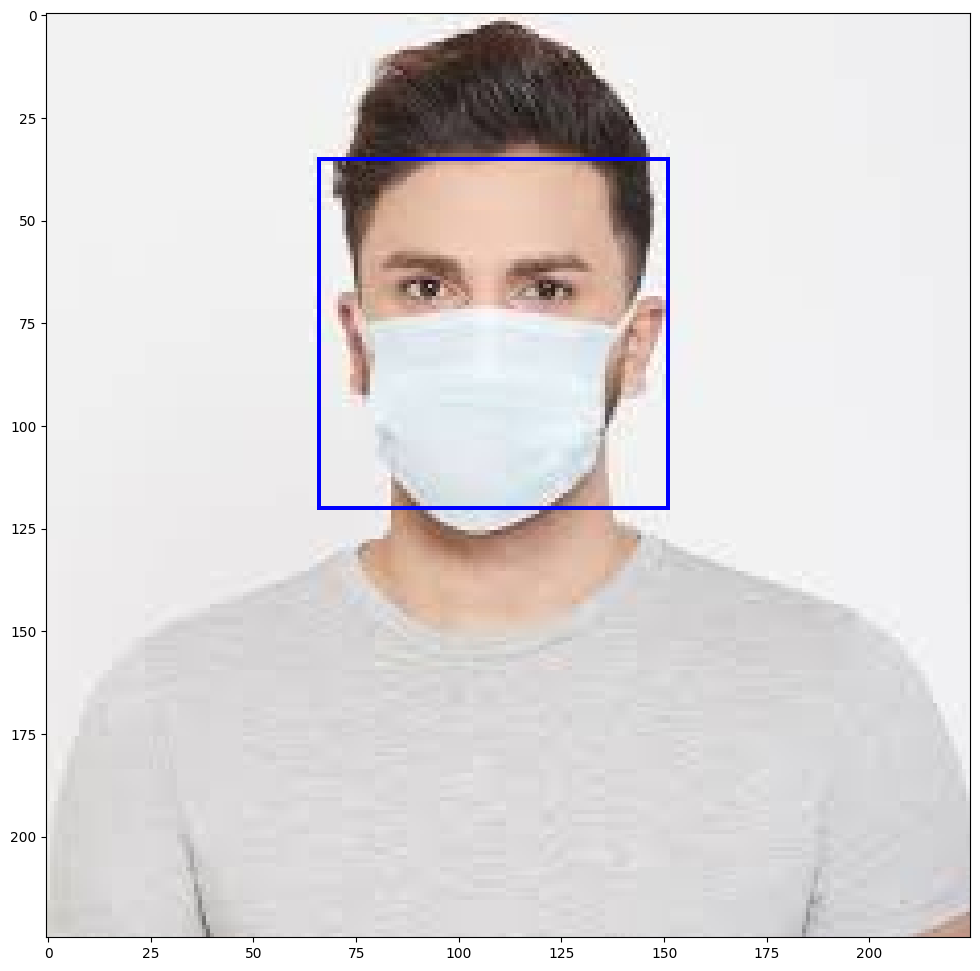

In [35]:
# Read a sample image
img = cv2.imread("/content/download.jpg")

# Keep a copy of coloured image
orig_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# Convert image to grayscale
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

# loading haarcascade_frontalface_default.xml
face_detection_model = cv2.CascadeClassifier("/content/haarcascade_frontalface_default.xml")

# detect faces in the given image
return_faces = face_detection_model.detectMultiScale(
    img, scaleFactor=1.08, minNeighbors=4
)  # returns a list of (x,y,w,h) tuples

# plotting the returned values
for (x, y, w, h) in return_faces:
    cv2.rectangle(orig_img, (x, y), (x + w, y + h), (0, 0, 255), 1)

plt.figure(figsize=(12, 12))
plt.imshow(orig_img)  # display the image

**Installed facenet-pytorch for MTCNN**

In [55]:
!pip install facenet_pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.w

**Since the haar-cascade algorithm was not very accurate**

**Used MTCNN for face detection**

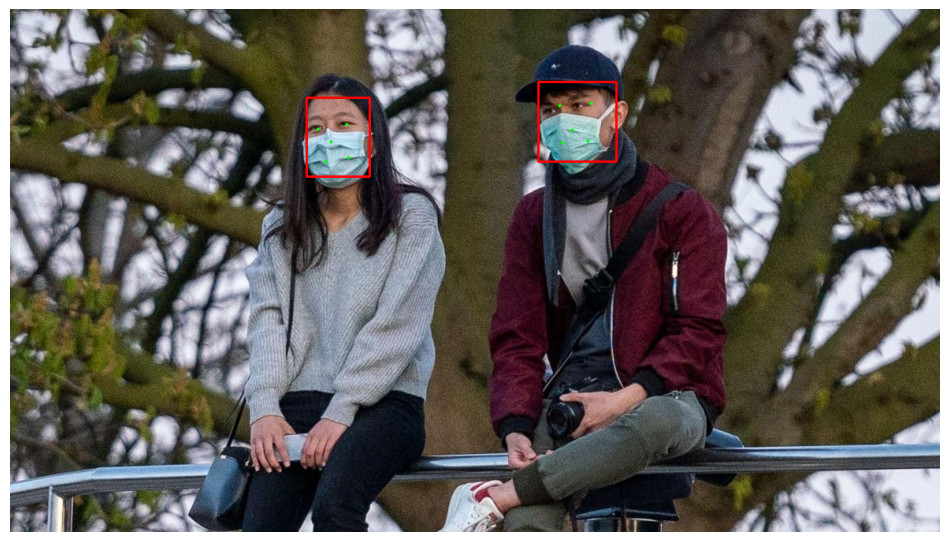

In [6]:
from facenet_pytorch import MTCNN
import cv2
import matplotlib.pyplot as plt
import torch

# Check if GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize MTCNN
mtcnn = MTCNN(keep_all=True, device=device)

# Load the image
img = cv2.imread("/content/1949.jpg")

# Convert the image to RGB (MTCNN expects images in RGB format)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Detect faces and landmarks
boxes, probs, landmarks = mtcnn.detect(rgb_img, landmarks=True)

# Draw rectangles around the detected faces and landmarks
if boxes is not None:
    for box, landmark in zip(boxes, landmarks):
        x, y, x2, y2 = box.astype(int)
        cv2.rectangle(img, (x, y), (x2, y2), (0, 0, 255), 2)

        for point in landmark:
            cv2.circle(img, tuple(point.astype(int)), 2, (0, 255, 0), -1)

# Convert BGR image to RGB for displaying with matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the output image
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.axis('off')  # Hide axis
plt.show()



**Define the target_size, class_mode and batch_size for the data**

In [13]:
# Train data
datagenerator = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2
)
train_generator = datagenerator.flow_from_directory(
    directory=train_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Validation data
val_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

# Test data
test_generator = datagenerator.flow_from_directory(
    directory=val_dir, target_size=(128, 128), class_mode="categorical", batch_size=32
)

Found 4598 images belonging to 2 classes.
Found 1800 images belonging to 2 classes.
Found 1800 images belonging to 2 classes.


**Initialize and complie the VGG19 model**

In [14]:
# Initializing the VGG19 model
vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

for layer in vgg19_model.layers:
    layer.trainable = False

# Initialize a sequential model
model = Sequential()
model.add(vgg19_model)
model.add(Flatten())
model.add(Dense(2, activation="sigmoid"))
model.summary()

# Compiling the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

80134624/80134624 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 20040770 (76.45 MB)
Trainable params: 16386 (64.01 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


**Train the model**

In [15]:
# Fit the model on train data along with validation data
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator) // 32,
)

<ipython-input-15-8f8a66f28a22>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/20
4/4 [==============================] - 48s 14s/step - loss: 0.7002 - accuracy: 0.6094 - val_loss: 1.0279 - val_accuracy: 0.5625
Epoch 2/20
4/4 [==============================] - 17s 5s/step - loss: 0.4437 - accuracy: 0.8125 - val_loss: 0.8202 - val_accuracy: 0.5312
Epoch 3/20
4/4 [==============================] - 12s 4s/step - loss: 0.4103 - accuracy: 0.7891 - val_loss: 0.8481 - val_accuracy: 0.5938
Epoch 4/20
4/4 [==============================] - 15s 5s/step - loss: 0.2827 - accuracy: 0.8828 - val_loss: 0.6820 - val_accuracy: 0.6250
Epoch 5/20
4/4 [==============================] - 11s 4s/step - loss: 0.3433 - accuracy: 0.8281 - val_loss: 0.5359 - val_accuracy: 0.7812
Epoch 6/20
4/4 [==============================] - 13s 4s/step - loss: 0.2490 - accuracy: 0.9141 - val_loss: 1.0406 - val_accuracy: 0.5312
Epoch 7/20
4/4 [==============================] - 11s 4s/step - loss: 0.2416 - accuracy: 0.9062 - val_loss: 0.8409 - val_accuracy: 0.5625
Epoch 8/20
4/4 [=================

**Evaluate the model on test data**

In [21]:
# Evaluate model performance on test data

model_loss, model_acc = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))

57/57 [==============================] - 17s 294ms/step - loss: 0.8005 - accuracy: 0.6717
Model has a loss of 0.80 and accuracy 67.17%


**Predict on the given image**

**The image chosen above for face detection is used here for prediction**

1/1 [==============================] - 0s 21ms/step


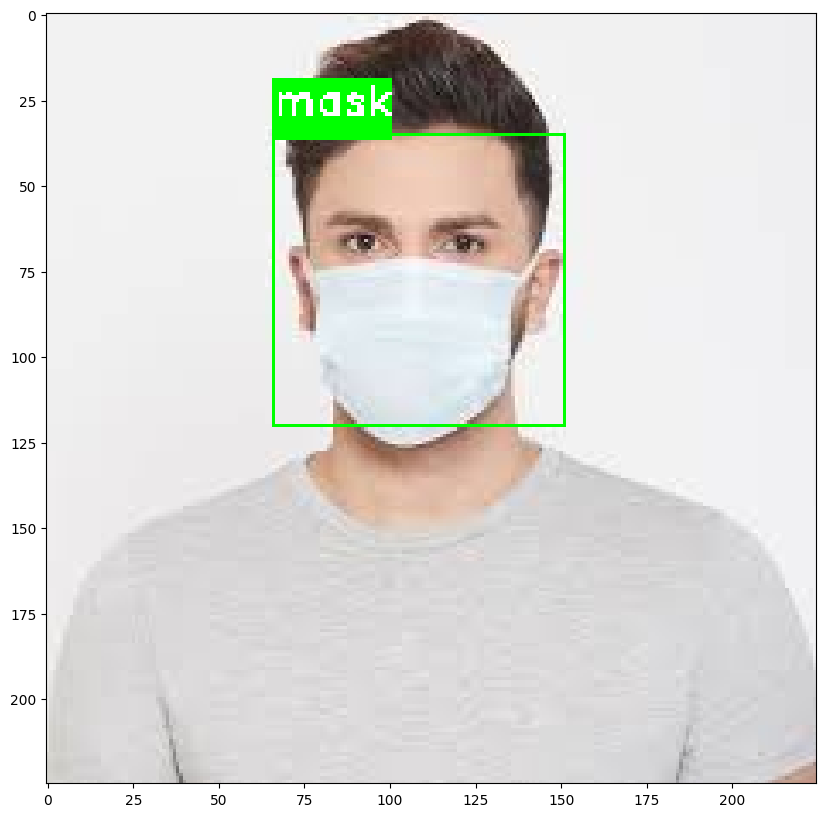

In [36]:
# label for mask detection

mask_det_label = {0: "no_mask", 1: "mask"}
mask_det_label_colour = {0: (255, 0, 0), 1: (0, 255, 0)}
pad_y = 1  # padding for result text

main_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

# For detected faces in the image
for i in range(len(return_faces)):
    (x, y, w, h) = return_faces[i]
    cropped_face = main_img[y : y + h, x : x + w]
    cropped_face = cv2.resize(cropped_face, (128, 128))
    cropped_face = np.reshape(cropped_face, [1, 128, 128, 3]) / 255.0
    mask_result = model.predict(cropped_face)  # make model prediction
    print_label = mask_det_label[mask_result.argmax()] # get mask/no mask based on prediction
    label_colour = mask_det_label_colour[mask_result.argmax()] # green for mask, red for no mask

    # Print result
    (t_w, t_h), _ = cv2.getTextSize(
        print_label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1
    )  # getting the text size

    cv2.rectangle(
        main_img,
        (x, y + pad_y),
        (x + t_w, y - t_h - pad_y - 6),
        label_colour,
        -1,
    )  # draw rectangle

    cv2.putText(
        main_img,
        print_label,
        (x, y - 6),
        cv2.FONT_HERSHEY_DUPLEX,
        0.4,
        (255, 255, 255), # white
        1,
    )  # print text

    cv2.rectangle(
        main_img,
        (x, y),
        (x + w, y + h),
        label_colour,
        1,
    )  # draw bounding box on face

plt.figure(figsize=(10, 10))
plt.imshow(main_img)  # display image

**Save the model in the content directory**

In [34]:
model.save("mask_detect.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Testing the model on video**

**each frame in video is processed individually in a loop
first face is detected then the model predicts wether it has mask or not**

In [40]:
import tensorflow as tf
import cv2
import numpy as np
import os

# Load the pre-trained model
model_path = '/content/mask_detect.h5'
new_model = tf.keras.models.load_model(model_path)

# Define the class labels
classes = ["without_mask", "with_mask"]

# Function to preprocess face for prediction
def preprocess_face(face):
    newImageArray = cv2.resize(face, (128, 128))
    image = np.array(newImageArray, dtype="float32")
    image = np.expand_dims(image, axis=0)
    return image

# Function to detect faces and predict mask/no mask
def detect_and_predict_mask(frame, face_cascade):
    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        processed_face = preprocess_face(face)

        # Make the prediction
        prediction = new_model.predict(processed_face)
        index = np.argmax(prediction[0], axis=0)
        label = classes[index]

        # Draw rectangle around the face and put label
        color = (0, 255, 0) if label == "with_mask" else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    return frame

# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Open video file or capture device
video_path = '/content/drive/MyDrive/Input_Videos/Test_video3.mp4'  # Change to your video path or use 0 for webcam
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Define the codec and create VideoWriter object
output_path = '/content/drive/MyDrive/output_video3.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces and predict mask status
    annotated_frame = detect_and_predict_mask(frame, face_cascade)

    # Write the frame into the file
    out.write(annotated_frame)

    # Display the resulting frame (optional)
    #cv2.imshow('Video', annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything when job is finished
cap.release()
out.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 21ms/step


In [44]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob

# Load the pre-trained model
model_path = '/content/mask_detect.h5'
new_model = tf.keras.models.load_model(model_path)

# Define the class labels
classes = ["without_mask", "with_mask"]

# Function to process and predict an image
def process_and_predict(image_path):
    # Read and preprocess the image
    imageArray = cv2.imread(image_path)
    newImageArray = cv2.resize(imageArray, (128, 128))

    # Prepare the image for prediction
    image = np.array(newImageArray, dtype="float32")
    image = np.expand_dims(image, axis=0)

    # Make the prediction
    prediction = new_model.predict(image)

    # Get the index of the highest probability
    index = np.argmax(prediction[0], axis=0)

    # Return the predicted class
    return classes[index]

# Specify the directory containing images
image_directory = '/content/drive/MyDrive/images_with_faces1'  # Change this to your image directory path

# Get a list of all image files in the directory
image_paths = glob(os.path.join(image_directory, '*.*'))  # Adjust the pattern if needed

# Load the existing CSV file or create a new DataFrame if it doesn't exist
csv_file_path = '/content/drive/MyDrive/results1.csv'
if os.path.exists(csv_file_path):
    df = pd.read_csv(csv_file_path)
else:
    df = pd.DataFrame(columns=["Image Path", "Prediction"])

# Iterate over each image and store the results
results = []
for image_path in image_paths:
    prediction = process_and_predict(image_path)
    results.append({"Image Path": image_path, "Prediction": prediction})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Append the results to the existing DataFrame
df = pd.concat([df, results_df], ignore_index=True)

# Save the updated DataFrame back to the CSV file
df.to_csv(csv_file_path, index=False)

print("Predictions saved to CSV file.")


1/1 [==============================] - 0s 18ms/step
Predictions saved to CSV file.


**Now to run the model on given set of images
from each face individual face is extracted and the dimensions are stored in .csv file along with the path,classname of the image after model predicts**

In [13]:
import numpy as np
import pandas as pd
import os
from glob import glob
import torch
from torchvision import transforms
from facenet_pytorch import MTCNN
import cv2
import tensorflow as tf

# Load the pre-trained model
model_path = '/content/mask_detect.h5'
new_model = tf.keras.models.load_model(model_path)

# Initialize MTCNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

# Define the class labels
classes = ["without_mask", "with_mask"]

# Function to process and predict faces in an image
def process_and_predict(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to read image at {image_path}")
        return None

    # Convert the image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces in the image
    boxes, probs = mtcnn.detect(image)

    if boxes is not None:
        results = []
        for box in boxes:
            x, y, w, h = box.astype(int)

            # Ensure bounding box coordinates are valid
            if x >= 0 and y >= 0 and w > 0 and h > 0:
                # Extract the face region
                face = image[y:y+h, x:x+w]

                # Resize and normalize the face image
                face = cv2.resize(face, (128, 128))
                face = face / 255.0

                # Prepare the face image for prediction
                face = np.expand_dims(face, axis=0)

                # Make the prediction
                prediction = new_model.predict(face)

                # Get the index of the highest probability
                index = np.argmax(prediction[0], axis=0)
                prediction_class = classes[index]

                # Save the result including face coordinates
                results.append({"Image Path": image_path, "Prediction": prediction_class, "x1": x, "y1": y, "x2": x+w, "y2": y+h})
            else:
                print(f"Invalid bounding box detected in {image_path}: {box}")

        return results
    else:
        print(f"No faces detected in {image_path}")
        return None

# Specify the directory containing images
image_directory = '/content/drive/MyDrive/images_with_faces1'  # Change this to your image directory path

# Get a list of all image files in the directory
image_paths = glob(os.path.join(image_directory, '*.*'))  # Adjust the pattern if needed

# Load the existing CSV file or create a new DataFrame if it doesn't exist
csv_file_path = '/content/drive/MyDrive/resultsfinal.csv'
if os.path.exists(csv_file_path):
    df = pd.read_csv(csv_file_path)
else:
    df = pd.DataFrame(columns=["Image Path", "Prediction", "x1", "y1", "x2", "y2"])

# Iterate over each image and store the results
results = []
for image_path in image_paths:
    face_predictions = process_and_predict(image_path)
    if face_predictions:
        results.extend(face_predictions)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Append the results to the existing DataFrame
df = pd.concat([df, results_df], ignore_index=True)

# Save the updated DataFrame back to the CSV file
df.to_csv(csv_file_path, index=False)

print("Predictions saved to CSV file.")


1/1 [==============================] - 0s 270ms/step
Invalid bounding box detected in /content/drive/MyDrive/images_with_faces1/0605.jpg: [-42.66872787475586 199.53414916992188 48.257591247558594
 324.3563232421875]
1/1 [==============================] - 0s 26ms/step
Invalid bounding box detected in /content/drive/MyDrive/images_with_faces1/0639.jpg: [108.04859924316406 -39.562957763671875 539.4891357421875
 479.2205810546875]
1/1 [==============================] - 0s 20ms/step
Invalid bounding box detected in /content/drive/MyDrive/images_with_faces1/0650.jpg: [-4.24245023727417 419.696044921875 439.82708740234375 931.2784423828125]
1/1 [==============================] - 0s 18ms/step
Invalid bounding box detected in /content/drive/MyDrive/images_with_faces1/0671.jpg: [184.74600219726562 -19.943674087524414 542.6884765625 426.53948974609375]
1/1 [==============================] - 0s 18ms/step
No faces detected in /content/drive/MyDrive/images_with_faces1/0712.jpg
1/1 [=================

**post-processing of the .csv file**

In [8]:
import csv

def edit_column(csv_file, column_index, string_to_remove):
    edited_rows = []
    with open(csv_file, 'r', newline='') as file:
        reader = csv.reader(file)
        for row in reader:
            if len(row) > column_index:
                # Edit the column
                column_value = row[column_index]
                edited_value = column_value.replace(string_to_remove, '')  # Remove the specified string
                row[column_index] = edited_value
            edited_rows.append(row)

    # Write the edited rows to a new CSV file
    edited_csv_file = csv_file.replace('.csv', '_submissions.csv')
    with open(edited_csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(edited_rows)

    print(f"Column {column_index} edited successfully. Edited CSV file saved as '{edited_csv_file}'.")

# Example usage:
csv_file_path = '/content/drive/MyDrive/resultsfinal.csv'  # Provide the path to your CSV file
column_index_to_edit = 0  # Index of the column to edit (0-based indexing)
string_to_remove = "/content/drive/MyDrive/images_with_faces1/"

edit_column(csv_file_path, column_index_to_edit, string_to_remove)


Column 0 edited successfully. Edited CSV file saved as '/content/drive/MyDrive/resultsfinal_submissions.csv'.


**post-processing of the .csv file**

In [9]:
import csv

def sort_column(csv_file, column_index):
    data = []
    with open(csv_file, 'r', newline='') as file:
        reader = csv.reader(file)
        for row in reader:
            data.append(row)

    data_sorted = sorted(data, key=lambda x: x[column_index])

    sorted_csv_file = csv_file.replace('.csv', '_sorted.csv')
    with open(sorted_csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data_sorted)

    print(f"Column {column_index} sorted successfully. Sorted CSV file saved as '{sorted_csv_file}'.")

# Example usage:
csv_file_path = '/content/resultsfinal_submissions.csv'  # Provide the path to your CSV file
column_index_to_sort = 0  # Index of the column to sort (0-based indexing)

sort_column(csv_file_path, column_index_to_sort)


Column 0 sorted successfully. Sorted CSV file saved as '/content/resultsfinal_submissions_sorted.csv'.
